### Imports

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Regression

### Loading Data

In [31]:
df = pd.read_csv('cleaned_fifa23.csv')

### Feature Selection

In [20]:
player_names = df["Full Name"]
actual_ovr = df["Overall"]
actual_pos = df["Best Position"]

#features 
drop_cols = ["Full Name", "Overall", "Best Position", "Club Name"]
features = df.drop(columns=[c for c in drop_cols if c in df.columns])

#scale numeric features (optional but good for ML)
scaler = StandardScaler()
X = scaler.fit_transform(features)

### Regression for OVR and Position

In [21]:
y_ovr = actual_ovr

X_train, X_test, y_train, y_test = train_test_split(X, y_ovr, test_size=0.2, random_state=42)

reg = RandomForestRegressor(random_state=42, n_estimators=200)
reg.fit(X_train, y_train)

y_pred_ovr = reg.predict(X_test)

print("Regression R²:", r2_score(y_test, y_pred_ovr))
print("Regression MAE:", mean_absolute_error(y_test, y_pred_ovr))

Regression R²: 0.9660889126600961
Regression MAE: 0.920515102481122


### Classification for Position


Exact Position Prediction
Accuracy: 0.6866235167206041
Report:
               precision    recall  f1-score   support

         CAM       0.61      0.78      0.69       420
          CB       0.84      0.94      0.89       691
         CDM       0.61      0.68      0.64       300
          CF       0.00      0.00      0.00        15
          CM       0.59      0.65      0.62       222
          GK       1.00      1.00      1.00       451
          LB       0.37      0.27      0.31       180
          LM       0.24      0.07      0.10       136
          LW       0.00      0.00      0.00        50
         LWB       0.24      0.07      0.11        86
          RB       0.30      0.33      0.32       195
          RM       0.42      0.47      0.45       281
          RW       0.19      0.04      0.07        74
         RWB       0.26      0.13      0.17        86
          ST       0.85      0.95      0.90       521

    accuracy                           0.69      3708
   macro avg   

c:\Users\anshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anshu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

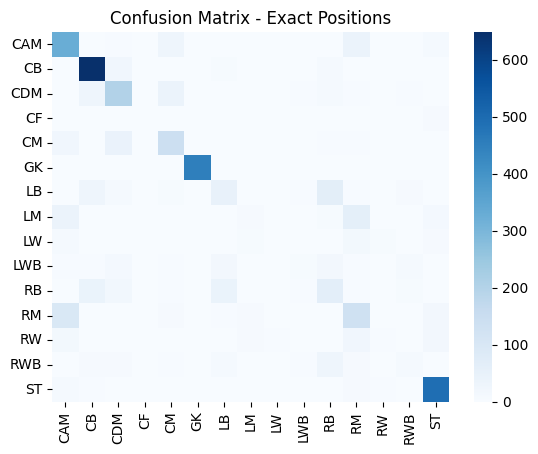

In [22]:
le_exact = LabelEncoder()
y_pos_exact = le_exact.fit_transform(actual_pos)

X_train, X_test, y_train, y_test = train_test_split(X, y_pos_exact, test_size=0.2, random_state=42)

clf_exact = RandomForestClassifier(random_state=42, n_estimators=300, class_weight="balanced")
clf_exact.fit(X_train, y_train)

y_pred_pos_exact = clf_exact.predict(X_test)

print("\nExact Position Prediction")
print("Accuracy:", accuracy_score(y_test, y_pred_pos_exact))
print("Report:\n", classification_report(y_test, y_pred_pos_exact, target_names=le_exact.classes_))

cm = confusion_matrix(y_test, y_pred_pos_exact)
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=le_exact.classes_, yticklabels=le_exact.classes_)
plt.title("Confusion Matrix - Exact Positions")
plt.show()

### Position Predcition


Grouped Position Prediction
Accuracy: 0.9042610571736786
Report:
               precision    recall  f1-score   support

         DEF       0.93      0.91      0.92      1238
         FWD       0.92      0.83      0.87       660
          GK       1.00      1.00      1.00       451
         MID       0.85      0.90      0.87      1359

    accuracy                           0.90      3708
   macro avg       0.92      0.91      0.92      3708
weighted avg       0.91      0.90      0.90      3708



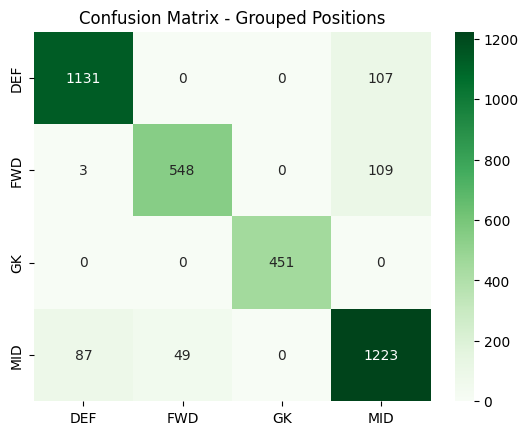

In [23]:
def simplify_position(pos):
    if pos in ["CB", "LB", "RB", "RWB", "LWB"]:
        return "DEF"
    elif pos in ["CM", "CDM", "CAM", "LM", "RM"]:
        return "MID"
    elif pos in ["ST", "CF", "LW", "RW"]:
        return "FWD"
    elif pos == "GK":
        return "GK"
    else:
        return "OTHER"

df["pos_group"] = df["Best Position"].apply(simplify_position)

le_group = LabelEncoder()
y_pos_group = le_group.fit_transform(df["pos_group"])

X_train, X_test, y_train, y_test = train_test_split(X, y_pos_group, test_size=0.2, random_state=42)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred_pos_group = xgb.predict(X_test)

print("\nGrouped Position Prediction")
print("Accuracy:", accuracy_score(y_test, y_pred_pos_group))
print("Report:\n", classification_report(y_test, y_pred_pos_group, target_names=le_group.classes_))

cm = confusion_matrix(y_test, y_pred_pos_group)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=le_group.classes_, yticklabels=le_group.classes_)
plt.title("Confusion Matrix - Grouped Positions")
plt.show()

#### Final Output

In [24]:
predicted_ovr = reg.predict(X)
predicted_pos_exact = le_exact.inverse_transform(clf_exact.predict(X))
predicted_pos_group = le_group.inverse_transform(xgb.predict(X))

results = pd.DataFrame({
    "Full Name": player_names,
    "Predicted OVR": predicted_ovr.round(1),
    "Actual OVR": actual_ovr,
    "Predicted Position (Exact)": predicted_pos_exact,
    "Actual Position": actual_pos,
    "Predicted Position (Grouped)": predicted_pos_group,
    "Actual Position (Grouped)": df["pos_group"]
})

print("\nSample Results:")
print(results.head())

results.to_csv("predictions.csv", index=False)


Sample Results:
            Full Name  Predicted OVR  Actual OVR Predicted Position (Exact)  \
0        Lionel Messi           89.0          91                        CAM   
1       Karim Benzema           90.2          91                         CF   
2  Robert Lewandowski           90.1          91                         ST   
3     Kevin De Bruyne           89.4          91                        CAM   
4       Kylian Mbappé           90.3          91                         ST   

  Actual Position Predicted Position (Grouped) Actual Position (Grouped)  
0             CAM                          FWD                       MID  
1              CF                          FWD                       FWD  
2              ST                          FWD                       FWD  
3              CM                          MID                       MID  
4              ST                          FWD                       FWD  


# Clustering

### Attributes

In [32]:
# (exclude identifiers, overall, position)
cluster_features = df.drop(columns=["Full Name", "Overall", "Best Position", "Club Name", "pos_group"], errors="ignore")
X_scaled = scaler.fit_transform(cluster_features)

# Choose k using elbow + silhouette if you want (here we fix k=6 for demo)
kmeans = KMeans(n_clusters=6, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

### PCA for visualization

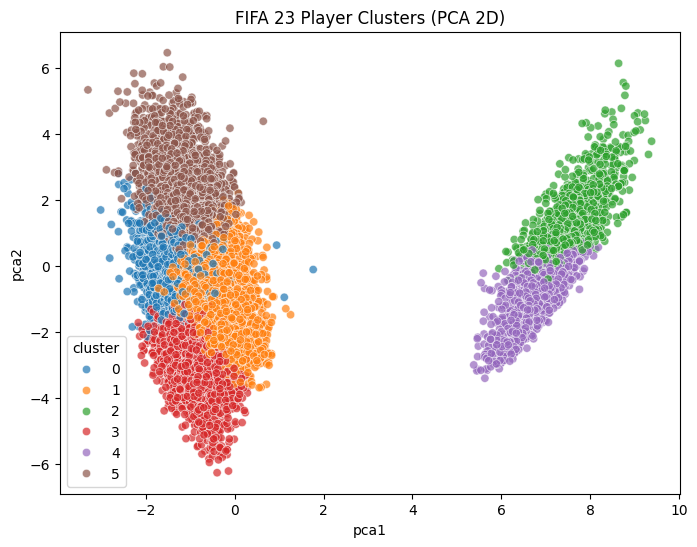

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df["pca1"], df["pca2"] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="tab10", alpha=0.7)
plt.title("FIFA 23 Player Clusters (PCA 2D)")
plt.show()

### Profiling

In [34]:
print("\nAverage OVR per cluster:")
print(df.groupby("cluster")["Overall"].mean().round(1))

print("\nMost common positions per cluster:")
print(df.groupby("cluster")["Best Position"].agg(lambda x: x.value_counts().index[0]))


Average OVR per cluster:
cluster
0    68.0
1    61.4
2    70.1
3    61.5
4    58.7
5    71.7
Name: Overall, dtype: float64

Most common positions per cluster:
cluster
0     CB
1     ST
2     GK
3     CB
4     GK
5    CAM
Name: Best Position, dtype: object


### Similar players

In [43]:
df["Predicted OVR"] = predicted_ovr.round(1)
df["Predicted Position (Exact)"] = predicted_pos_exact

def recommend_similar_players(player_name, n=5):
    """Return top-n most similar players to the given player (same cluster)."""
    if player_name not in df["Full Name"].values:
        return f"{player_name} not found in dataset"
    
    player_row = df[df["Full Name"] == player_name].iloc[0]
    cluster_id = player_row["cluster"]
    
    cluster_df = df[df["cluster"] == cluster_id].copy()
    X_cluster = X_scaled[df["cluster"] == cluster_id]
    
    # distances within the cluster
    distances = euclidean_distances([X_scaled[df["Full Name"] == player_name][0]], X_cluster)[0]
    cluster_df["distance"] = distances
    
    # sort by distance
    recommendations = cluster_df.sort_values("distance").head(n+1)  # +1 to include self
    return recommendations[["Full Name", "Overall", "Best Position", "Predicted OVR", "Predicted Position (Exact)", "distance"]].iloc[1:]

# Example usage:
print("\nSimilar players to 'Heung Min Son':")
print(recommend_similar_players("Heung Min Son", n=5))


Similar players to 'Heung Min Son':
            Full Name  Overall Best Position  Predicted OVR  \
135        Leroy Sané       84            LM           83.9   
5       Mohamed Salah       90            RW           89.9   
98   Domenico Berardi       84            RM           84.1   
476    Joaquín Correa       80            RW           80.2   
119       Eden Hazard       84            LW           84.2   

    Predicted Position (Exact)  distance  
135                         ST  1.168533  
5                           RW  1.327884  
98                          RM  1.415353  
476                        CAM  1.444951  
119                         RW  1.478678  
